# Init

## Notebook extensions

Allows for real-time modules' code update

In [23]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
%autoreload 2

## Prerequisites

The libraries that are needed in order for the project to work

In [25]:
import numpy as np # Working with tensors

In [26]:
import silero_vad # Fast VAD

In [27]:
import matplotlib.pyplot as plt # Data visualization

In [28]:
import seaborn as sns # For easier visualization in certain places

In [29]:
import os # Managing dataset files and restarting the kernel

In [30]:
import librosa # Audio processing

In [31]:
import pandas as pd # For dataframes

In [32]:
import tensorflow as tf # NN framework

In [33]:
from tqdm.notebook import tqdm # Progress bars

In [34]:
from sklearn.model_selection import train_test_split # Contains useful utilities for working with the model
from sklearn.decomposition import PCA
from sklearn.utils.class_weight import compute_class_weight

In [35]:
import audiomentations # Audio augmentations

In [36]:
from IPython.display import Audio # For an audio widget inside of the notebook

In [37]:
from types import MappingProxyType # Immutable dictionary

In [38]:
import scipy # Contains signal filters

In [39]:
import soundfile as sf

In [40]:
import sys # To import modules of the parent folder

## Custom modules

In [41]:
sys.path.append('../')
from config import Config # Configuration variables
import processing

## Dataset-related constants

In [42]:
STR_TO_EMOTION = MappingProxyType({
    '01': 'neutral',
    '03': 'happy',
    '05': 'angry',
    '08': 'surprise',
    '04': 'sad',
    
    '02': 'neutral', # Calm considered as neutral to expand the dataset 
    # '06': 'fearful', Excluded for compatibility
    # '07': 'disgust',
})

STR_TO_INTENSITY = MappingProxyType({
    '01': 'normal',
    '02': 'strong',
})

def get_speaker_gender(str):
    return 'female' if int(str) % 2 == 0  else 'male'

## Configuration

In [43]:
cfg = Config() # Values inside config.py are used by default

In [44]:
vad_model = silero_vad.load_silero_vad()

# Pre-training

## Dataset preprocessing

"The Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS)" by Livingstone & Russo is licensed under CC BY-NA-SC 4.0.

> The dataset has been downloaded as a .zip archive from
>
>
> https://www.kaggle.com/datasets/uwrfkaggler/ravdess-emotional-speech-audio/data
>
>
> Folders Actor 1 ... 24 were then unpacked to the `./research/dataset/RAVDESS` directory of the project

Kun Zhou, Berrak Sisman, Rui Liu and Haizhou Li, "Seen and unseen emotional style transfer for voice conversion with a new emotional speech dataset" ICASSP 2021-2021 IEEE International Conference on Acoustics, Speech and Signal Processing (ICASSP)

> The dataset has been downloaded as a .zip archive from
>
>
> https://github.com/HLTSingapore/Emotional-Speech-Data
>
>
> Folders 0001...0020 were then unpacked to the `./research/dataset/ESD` directory of the project

### Loading the information

In [45]:
dataset_information = pd.DataFrame(columns=['filepath', 'emotion'])

In [46]:
for dirname, _, filenames in os.walk('./dataset/RAVDESS'):
    for filename in filenames:
        if filename == '.gitignore': continue
        params = filename[:-4].split('-')
        if params[2] not in ['06', '07']:
            dataset_information.loc[len(dataset_information)] = [os.path.join(dirname, filename),  
                                                                 STR_TO_EMOTION[params[2]]]

folder_by_speaker = []

for dirname in os.listdir('./dataset/ESD'):
    if dirname == '.gitignore': continue
    folder_by_speaker.append(dirname)

folder_by_emotion = ['Surprise', 'Neutral', 'Happy', 'Sad', 'Angry']

for speaker_folder in folder_by_speaker:
    for emotion_folder in folder_by_emotion:
        for filename in os.listdir(f'./dataset/ESD/{speaker_folder}/{emotion_folder}'):
            if (filename[0] == '.'): continue
            dataset_information.loc[len(dataset_information)] = [f'./dataset/ESD/{speaker_folder}/{emotion_folder}/{filename}', emotion_folder.lower()]

In [47]:
dataset_information.sample(10)

,filepath,emotion
1996,./dataset/ESD/0017/Happy/0017_000785.wav,happy
8118,./dataset/ESD/0009/Surprise/0009_001606.wav,surprise
34462,./dataset/ESD/0012/Surprise/0012_001643.wav,surprise
20143,./dataset/ESD/0003/Angry/0003_000450.wav,angry
30965,./dataset/ESD/0013/Surprise/0013_001748.wav,surprise
20420,./dataset/ESD/0002/Surprise/0002_001433.wav,surprise
4763,./dataset/ESD/0018/Surprise/0018_001708.wav,surprise
3444,./dataset/ESD/0020/Neutral/0020_000260.wav,neutral
13960,./dataset/ESD/0011/Neutral/0011_000223.wav,neutral
16929,./dataset/ESD/0006/Surprise/0006_001543.wav,surprise


Checking if the dataset is balanced across the classes:

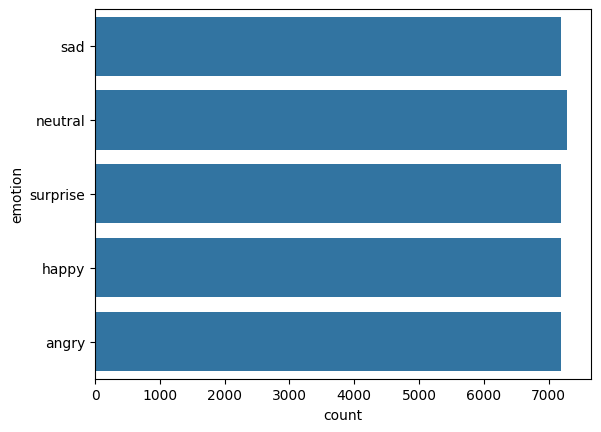

In [48]:
_ = sns.countplot(dataset_information['emotion']) # How many samples of each emotion are there

> Good so far

### Processing functions

In [49]:
def preprocess(data, cfg, original_sr):
    vad_result = silero_vad.get_speech_timestamps(data, vad_model, return_seconds=False) # Extracting only voice data from the input

    voice_data = []
    
    for voice_detection in vad_result:
        voice_data.append(data[voice_detection['start']:voice_detection['end']])

    if not voice_data: return None
    
    result = np.hstack(voice_data)
    
    if len(result) < cfg.input_size: return None
    
    result = librosa.effects.preemphasis(result)    
    
    b, a = scipy.signal.butter(5, 25 / cfg.sr, 'high') # A highpass filter with 20Hz cutoff frequency 
    result = scipy.signal.filtfilt(b, a, result, method='gust', axis=0) # Gust method works better than the default one

    res_max = np.abs(result).max() # Data normalization
    result = 0.9 * (result) / (res_max)
    
    return result

### Observing the data

In [50]:
def make_plots(title, cfg, data):
    fig, ax = plt.subplots(nrows=1, ncols=3)
    
    fig.suptitle(title)
    fig.set_size_inches(10, 2.5)
    
    ax[0].set(title='Time-ampitude')
    ax[1].set(title='Mel')
    ax[2].set(title='MFCC')

    feature_mel = librosa.feature.melspectrogram(y=data, sr=cfg.sr, n_fft=cfg.n_fft, win_length=cfg.window_len, window=cfg.window_type, hop_length=cfg.hop_len)
    feature_mfcc = librosa.feature.mfcc(y=data, sr=cfg.sr, n_fft=cfg.n_fft, n_mfcc=cfg.n_mfcc, win_length=cfg.window_len, window=cfg.window_type, hop_length=cfg.hop_len)
    
    time_amplitude = librosa.display.waveshow(y=data, sr=sr, ax=ax[0], color='purple', transpose = False) # Color is explicitly specified to avoid librosa's bug    
    mel = librosa.display.specshow(data=librosa.power_to_db(feature_mel), sr=cfg.sr, ax=ax[1], x_axis='time', y_axis='mel')
    mfcc = librosa.display.specshow(data=feature_mfcc, sr=sr, ax=ax[2], x_axis='time')
    
    fig.tight_layout()

In [55]:
unique_label_samples = dataset_information.sample(frac=1).drop_duplicates(subset=['emotion']) # Random sample of each emotion from the dataset
unique_label_samples

,filepath,emotion
24006,./dataset/ESD/0019/Surprise/0019_001729.wav,surprise
19584,./dataset/ESD/0003/Happy/0003_000958.wav,happy
32923,./dataset/ESD/0005/Neutral/0005_000350.wav,neutral
30711,./dataset/ESD/0004/Angry/0004_000443.wav,angry
9331,./dataset/ESD/0009/Sad/0009_001225.wav,sad


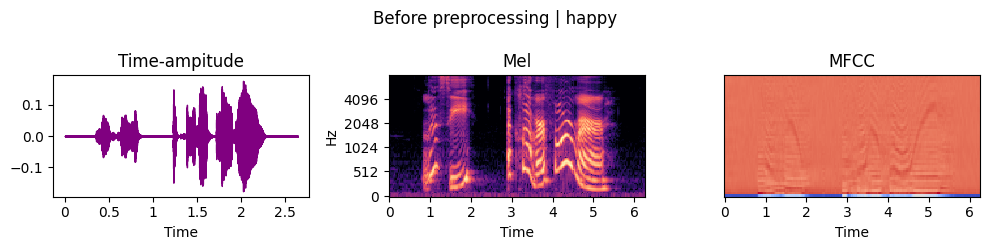

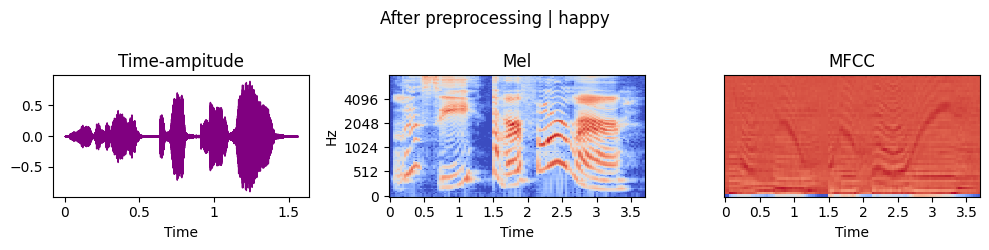

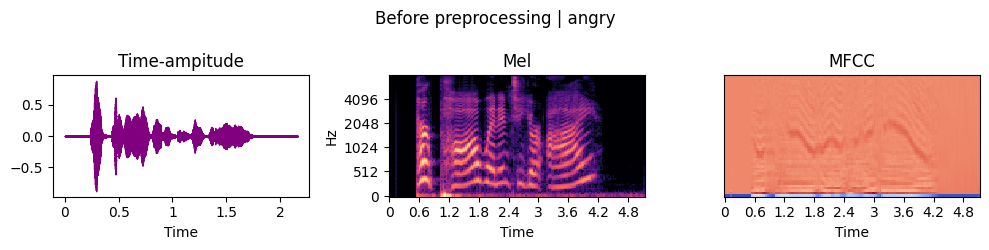

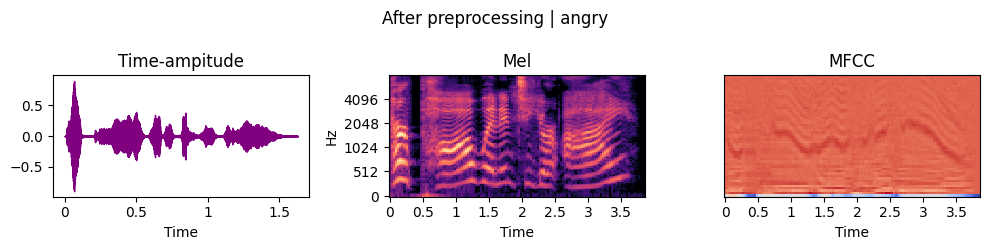

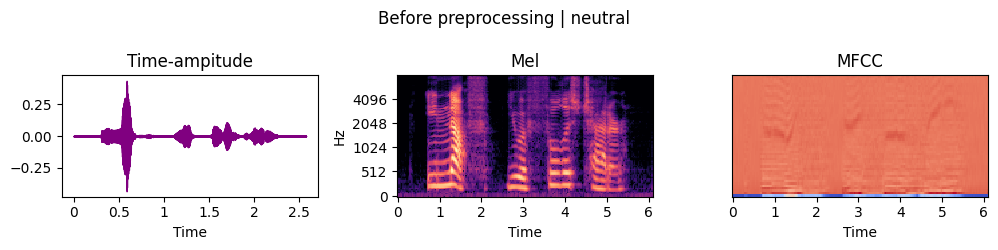

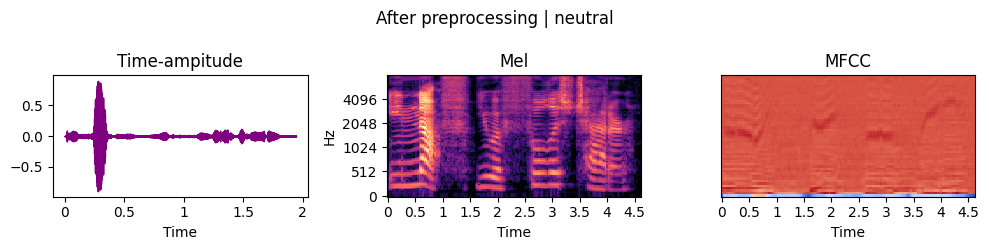

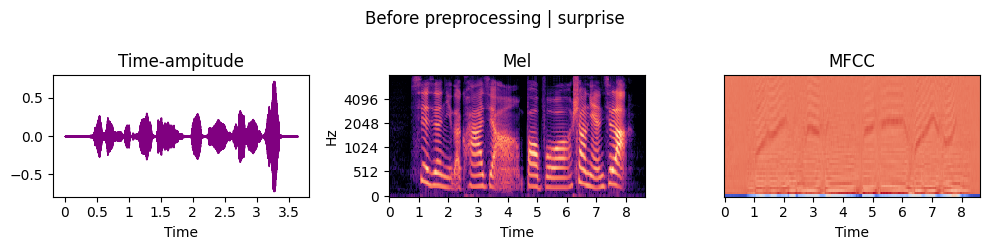

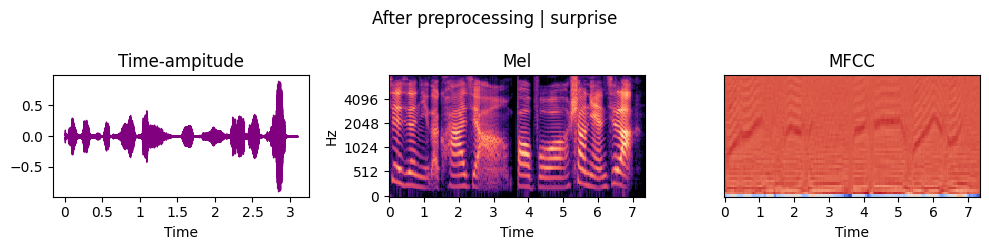

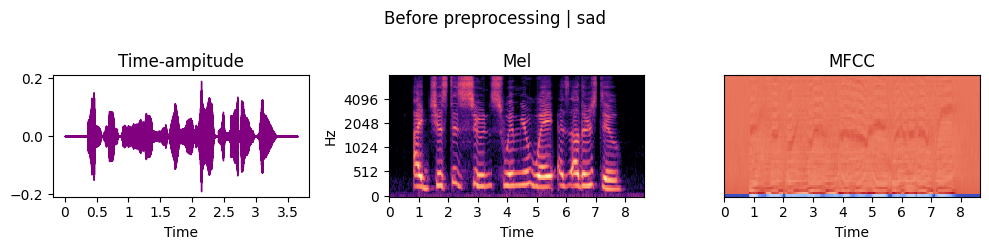

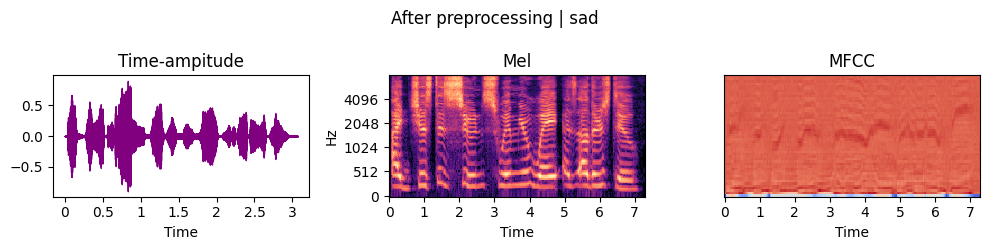

In [54]:
stop_after = 5 # Show for each emotion by default

for index, sample in unique_label_samples.iterrows():
    stop_after -= 1
    if stop_after < 0: break

    data, sr = librosa.load(sample.filepath, sr=cfg.sr)
    
    make_plots(f'Before preprocessing | {sample.emotion}', cfg, data)
    make_plots(f'After preprocessing | {sample.emotion}', cfg, preprocess(data, cfg, cfg.sr))

In [ ]:
listen_sample_data, _ = librosa.load(dataset_information.sample(1).iloc[0].filepath, sr=cfg.sr)

In [ ]:
Audio(listen_sample_data, rate=cfg.sr) # Before preprocessing

In [ ]:
Audio(preprocess(listen_sample_data, cfg, cfg.sr), rate=cfg.sr) # After preprocessing

### Loading all data

In [ ]:
dataset_already_processed = len(os.listdir('processed')) != 0

In [ ]:
labels = set()

In [ ]:
_ = [labels.add(label) for label in STR_TO_EMOTION.values()]

In [ ]:
samples = dict(zip(list(labels), [[], [], [], [], []]))

In [ ]:
if not dataset_already_processed:
    for _, sample in tqdm(dataset_information.iterrows(), total=dataset_information.shape[0] - 1, desc='Loading the dataset'):
        data, sr = librosa.load(sample.filepath, sr=cfg.sr)
        if data is not None:
            samples[sample.emotion].append(data)

### Data Augmentation

> Impulse Responses from https://mcdermottlab.mit.edu/Reverb/IR_Survey.html
> 
> Should be copied under the directory of `./research/impulse_responses` (if needed)

In [51]:
augment = audiomentations.Compose([
    # audiomentations.PitchShift(min_semitones=-1, max_semitones=1, p=1.0),
    # audiomentations.ApplyImpulseResponse(ir_path='impulse_responses', p=1.0),
    audiomentations.AddGaussianNoise(min_amplitude=0.003, max_amplitude=0.003, p=1.0),
    # audiomentations.AddColorNoise(p=1.0),
    audiomentations.LowPassFilter(p=1.0),
    audiomentations.HighPassFilter(p=1.0),
])

In [52]:
Audio(augment(samples=np.array(samples['surprise'][200]), sample_rate=cfg.sr), rate=cfg.sr) # Augmentation playground

NameError: name 'samples' is not defined

In [ ]:
samples_per_class = 5000

In [ ]:
if not dataset_already_processed:
    augmentation_failed = 0
    
    for emotion in samples:
        augment = audiomentations.Compose([
            # audiomentations.PitchShift(min_semitones=-1, max_semitones=1, p=0.1),
            # audiomentations.ApplyImpulseResponse(ir_path='impulse_responses', p=0.1),
            audiomentations.AddGaussianNoise(max_amplitude=0.002, p=0.2),
            audiomentations.LowPassFilter(p=0.2),
            audiomentations.HighPassFilter(p=0.2),
        ])
        
        for i in tqdm(range(samples_per_class), desc=emotion):    
            random_index = np.random.randint(0, len(samples[emotion]))
            preprocessed_sample = preprocess(samples[emotion][random_index], cfg, cfg.sr)
            
            while preprocessed_sample is None:
                random_index = np.random.randint(0, len(samples[emotion]))
                preprocessed_sample = preprocess(samples[emotion][random_index], cfg, cfg.sr)        

            start_index_random = np.random.randint(0, len(preprocessed_sample) - cfg.input_size)

            # Write augmented file, or the original one if augmentation fails
            try:
                sf.write(f'processed/{emotion}_{i}.wav', augment(samples=preprocessed_sample[start_index_random:start_index_random+cfg.input_size], sample_rate=cfg.sr), samplerate=cfg.sr)
            except Exception as e:
                sf.write(f'processed/{emotion}_{i}.wav', np.array(preprocess(samples[emotion][random_index])), cfg.sr)
                augmentation_failed += 1
                print(e)

    print(f'Augmentation failed {augmentation_failed} times during the whole process')

In [ ]:
os._exit(00) # restarts jupyter kernel to free up memory

# Training the model

In [137]:
mode = 'lstm' # 'lstm', 'cnn'
feature = 'mfcc' # 'mel', 'mfcc'

In [138]:
X, Y = [], []

In [139]:
for file in tqdm(os.listdir('processed'), desc='Calculating the features'):
    if 'wav' not in file: continue
    data, sr = librosa.load('processed/' + file)
    for i in range(0, len(data) - cfg.input_size, cfg.input_size):
        if feature == 'mel': selected_feature = librosa.feature.melspectrogram(y=data[i:i+cfg.input_size], sr=cfg.sr, n_fft=cfg.n_fft, win_length=cfg.window_len, window=cfg.window_type, hop_length=cfg.hop_len)
        elif feature == 'mfcc': selected_feature = librosa.feature.mfcc(y=data[i:i+cfg.input_size], sr=cfg.sr, n_fft=cfg.n_fft, n_mfcc=cfg.n_mfcc), win_length=cfg.window_len, window=cfg.window_type, hop_length=cfg.hop_len)

        if mode == 'lstm':
            X.append(np.swapaxes(selected_feature, 0, 1))
        elif mode == 'cnn' or mode == 'mixed': X.append(selected_feature)
                 
        Y.append(file.split('_')[0])

Calculating the features:   0%|          | 0/25000 [00:00<?, ?it/s]

<Axes: xlabel='count'>

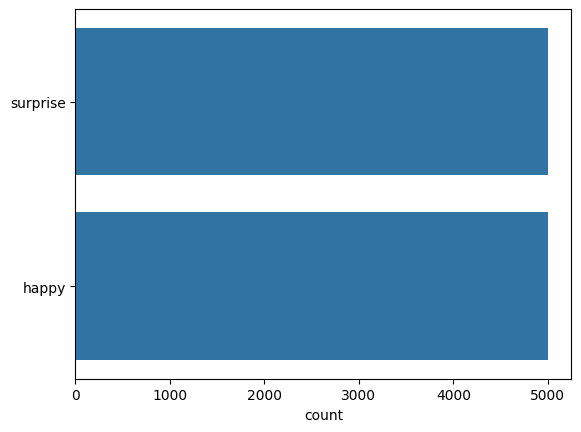

In [140]:
sns.countplot(Y)

In [141]:
classes = np.unique(Y)

In [142]:
class_weights = compute_class_weight('balanced', classes=classes, y=Y)

In [143]:
class_weights = {i: class_weights[i] for i in range(len(class_weights))}

In [144]:
onehot_enc = tf.keras.utils.to_categorical([i for i in range(len(classes))])

In [145]:
onehot_map = {classes: encoding for classes, encoding in zip(classes, onehot_enc)}

In [146]:
print(onehot_map)

{'happy': array([1., 0.]), 'surprise': array([0., 1.])}


> Note that train_test_split() already shuffles all the data by default

In [147]:
X_train, X_val_test, Y_train, Y_val_test = train_test_split(X, [onehot_map[Y] for Y in Y], test_size=0.3) # 30% - for validation and test sets

In [148]:
X_val, X_test, Y_val, Y_test = train_test_split(X_val_test, Y_val_test, test_size=0.5) # 15% for validation and 15% for test (50% of 30%)

In [149]:
input_shape = np.array(X_train).shape
print(input_shape)

(7000, 75, 50)


In [150]:
if mode == 'lstm':
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=input_shape[1:]))
    model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(64, activation='relu')))
    model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(64, activation='relu')))
    model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(32, activation='relu')))
    model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(16, activation='relu')))
    model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(8, activation='relu')))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(len(onehot_map), activation='softmax'))
    
elif mode == 'cnn':
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=(input_shape[1], input_shape[2], 1)))
    model.add(tf.keras.layers.Conv2D(16, (3,3), activation='relu', strides=(1,1), padding='same'))
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.Conv2D(16, (3,3), activation='relu', strides=(1,1), padding='same'))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Conv2D(8, (3,3), activation='relu', strides=(1,1), padding='same'))
    model.add(tf.keras.layers.MaxPool2D((2,2)))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dense(16, activation='relu'))
    model.add(tf.keras.layers.Dense(8, activation='relu'))
    model.add(tf.keras.layers.Dense(len(onehot_map), activation='softmax'))

In [151]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_12                │ (None, 75, 128)        │        58,880 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 75, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_13                │ (None, 75, 128)        │        98,816 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 75, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_14                │ (None, 75, 128)        │        98,816 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 75, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_20             │ (None, 75, 64)         │         8,256 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_21             │ (None, 75, 64)         │         4,160 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_22             │ (None, 75, 32)         │         2,080 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_23             │ (None, 75, 16)         │           528 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_24             │ (None, 75, 8)          │           136 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 600)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 2)              │         1,202 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 272,874 (1.04 MB)

 Trainable params: 272,874 (1.04 MB)

 Non-trainable params: 0 (0.00 B)

In [152]:
import time, datetime
timestamp_str = '-'.join(str(datetime.datetime.fromtimestamp(time.time())).split())
print(f'../models/emvoia-{timestamp_str}.keras')

../models/emvoia-2025-01-06-14:27:48.228741.keras


In [153]:
X_val = np.array(X_val)
Y_val = np.array(Y_val)

In [154]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(f'../models/emvoia-{timestamp_str}.keras', monitor='val_acc', verbose=1, mode='max', save_best_only=True, save_weights_only=False)

In [155]:
history = model.fit(np.array(X_train), np.array(Y_train), epochs=10, batch_size=128, verbose=1, class_weight=class_weights, validation_data=(X_val, Y_val), callbacks=[checkpoint])

Epoch 1/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step - acc: 0.5105 - loss: 0.6930
Epoch 1: val_acc improved from -inf to 0.58267, saving model to ../models/emvoia-2025-01-06-14:27:48.228741.keras
55/55 ━━━━━━━━━━━━━━━━━━━━ 42s 480ms/step - acc: 0.5108 - loss: 0.6930 - val_acc: 0.5827 - val_loss: 0.6731
Epoch 2/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step - acc: 0.5866 - loss: 0.6703
Epoch 2: val_acc improved from 0.58267 to 0.59867, saving model to ../models/emvoia-2025-01-06-14:27:48.228741.keras
55/55 ━━━━━━━━━━━━━━━━━━━━ 24s 429ms/step - acc: 0.5867 - loss: 0.6702 - val_acc: 0.5987 - val_loss: 0.6646
Epoch 3/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step - acc: 0.6334 - loss: 0.6248
Epoch 3: val_acc improved from 0.59867 to 0.63067, saving model to ../models/emvoia-2025-01-06-14:27:48.228741.keras
55/55 ━━━━━━━━━━━━━━━━━━━━ 24s 428ms/step - acc: 0.6334 - loss: 0.6248 - val_acc: 0.6307 - val_loss: 0.6233
Epoch 4/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step - acc: 0.6738 - loss: 0.5944
Epoc

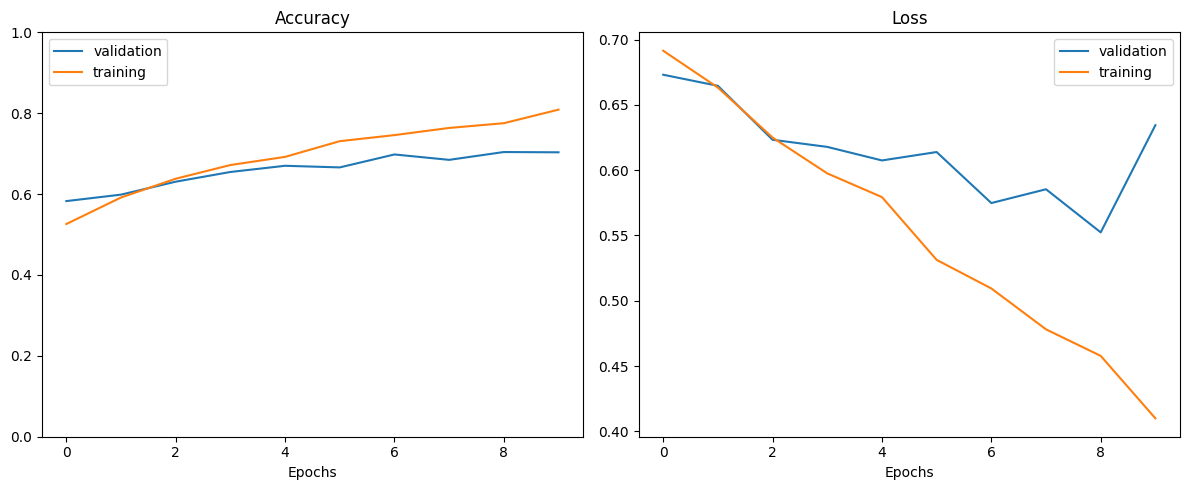

In [156]:
fig, ax = plt.subplots(nrows=1, ncols=2, sharex=True)
fig.set_size_inches(12, 5)

ax[0].set(title='Accuracy', xlabel='Epochs')
ax[1].set(title='Loss', xlabel='Epochs')

plt.sca(ax[0])
plt.ylim(0, 1)

val_acc = ax[0].plot(history.history['val_acc'], label='validation')
train_acc = ax[0].plot(history.history['acc'], label='training')

val_loss = ax[1].plot(history.history['val_loss'], label='validation')
train_loss = ax[1].plot(history.history['loss'], label='training')

ax[0].legend(loc='upper left')
ax[1].legend(loc='upper right')

fig.tight_layout()

In [157]:
def onehot_to_emotion(array):
    return list(onehot_map)[np.argmax(array)]

In [158]:
def predict(model, input):
    return model.predict(np.expand_dims(input, axis=0), verbose=0)

In [159]:
def confusion_matrix(confusion_matrix_counter):
    confusion_matrix = pd.DataFrame(confusion_matrix_counter / confusion_matrix_counter.sum(axis=1), columns=classes, index=classes)
    ax = sns.heatmap(pd.DataFrame(confusion_matrix, columns=classes, index=classes), annot=True, vmin=0, vmax=1, fmt='.2f', linewidths=0.1, linecolor='black')
    plt.ylabel('True classes')
    plt.xlabel('Model predictions')
    plt.tight_layout()
    _ = ax.set(title='Confusion matrix')

## Validation

In [160]:
confusion_matrix_counter_for_val = np.matrix([[0 for i in range(len(onehot_map))] for i in range(len(onehot_map))])

In [161]:
for i in tqdm(range(len(X_val)), desc='Predicting validation labels'):
    x, y = np.argmax(Y_val[i]), np.argmax(predict(model, X_val[i]))
    confusion_matrix_counter_for_val[x, y] += 1

Predicting validation labels:   0%|          | 0/1500 [00:00<?, ?it/s]

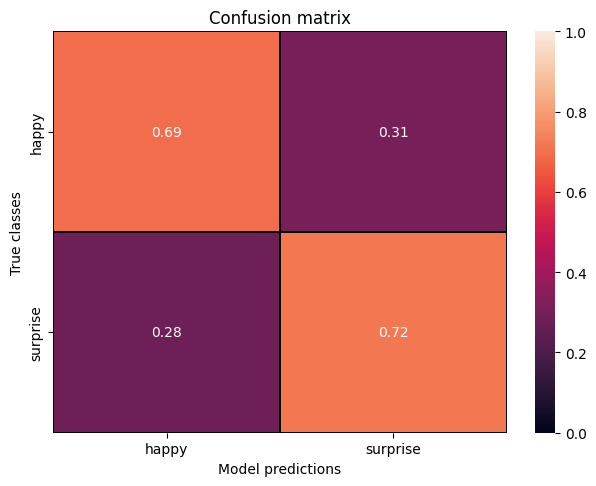

In [162]:
confusion_matrix(confusion_matrix_counter_for_val)

## Test

In [ ]:
confusion_matrix_counter_for_test = np.matrix([[0 for i in range(len(onehot_map))] for i in range(len(onehot_map))])

In [ ]:
for i in tqdm(range(len(X_test)), desc='Predicting test labels'):
    x, y = np.argmax(Y_test[i]), np.argmax(predict(model, X_test[i]))
    confusion_matrix_counter_for_test[x, y] += 1

In [ ]:
confusion_matrix(confusion_matrix_counter_for_test)

## Ensemble Test

66% model is better at recognizing surprise, and 64% one is better at recognizing happiness, so they can be combined to enhance overall accuracy

In [ ]:
from keras import saving

In [ ]:
model_66 = saving.load_model('../models/66accuracy_mfcc_bigger.keras')
model_64 = saving.load_model('../models/64accuracy_mfcc_light.keras')

In [ ]:
confusion_matrix_counter_for_ensemble_test = np.matrix([[0 for i in range(len(onehot_map))] for i in range(len(onehot_map))])

In [ ]:
for i in tqdm(range(len(X_test)), desc='Predicting test labels'):
    x, y = np.argmax(Y_test[i]), np.argmax(predict(model_66, X_test[i]) + predict(model_64, X_test[i]))
    confusion_matrix_counter_for_ensemble_test[x, y] += 1

In [ ]:
confusion_matrix(confusion_matrix_counter_for_ensemble_test)